# Mapping Short-Term Rental Patterns and Housing Pressure Signals in Cape Town

**Notebook 4: Modelling Affordability Pressure**

**Purpose:**  
This notebook extends the spatial analysis from previous notebooks by modelling the internal drivers of short-term rental pressure in Cape Town. Using Airbnb-derived metrics—price, listing density, review activity, and availability. It explores how these factors contribute to a composite Affordability Pressure Index (API). 

The aim is not to predict real-world affordability outcomes, but rather to assess which internal short term rental activity patterns exert the greatest influence on the pressure index.

***Note***
The pressure index is constructed from the same four metrics used as predictors, hence the modelling results reveal the relative internal weighting of these components rather than externally validated measures of housing stress.

## 1. Common notebook setup
### 1.1 Import required libraries

In [7]:
# Import libraries
import sys
sys.path.append("..") # Move up project root to import config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Enable inline plotting (for Jupyter)
%matplotlib inline

# Import config file
import config

# For interactive maps
import folium
import json
from folium.plugins import MarkerCluster

### 1.2 Color palette and styling

In [8]:
# Define the color palette
palette = ["#68174c", "#df586a", "#fd9c74", "#fdc48e", "#ffebc8"]

# Set Seaborn styling
sns.set_style("whitegrid")
sns.set_palette(palette)

# Set Matplotlib rcParams for consistent styling
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['font.family'] = 'DejaVu Serif'

# Create a continuous colormap for visualisations
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", 
                                                palette).reversed()

### 1.3 Define helper functions

In [9]:
# Helper function to load files
def load_csv(path, compression=None, name="Dataset"):
    """ Load CSV with optional compression and display message."""
    if os.path.exists(path):
        df = pd.read_csv(path, compression=compression)
        if df.empty:
            print(f"{name} loaded but is empty.")
        else:
            print(f"{name} loaded successfully.")
        return df
    else:
        print(f"{name} not found: {path}")
        return None

    
# Helper function to check for missing values
def check_missing_data(df, name="Dataset"):
    missing_values = df.isnull().sum().reset_index()
    missing_values.columns = ["Column", "Missing Values"]
    missing_values["% Missing"] = (missing_values["Missing Values"] / 
                                   len(df) * 100).round(2)
    total_missing = missing_values["Missing Values"].sum()

    if total_missing == 0:
        print(f"No missing data found in {name}.")
    else:
        print(f"Missing data summary for {name}:")
        print(missing_values[missing_values["Missing Values"] > 0])

### 1.4 Load the datasets

In [10]:
# Define path to the dataset
filepath_listings = config.LISTINGS_FILE
filepath_calendar = config.CALENDAR_FILE
filepath_gdf = config.GDF_FILE

# Load listings
listings_df = load_csv(filepath_listings, name="Listings")

# Load calendar
calendar_df = load_csv(filepath_calendar, compression="gzip", name="Calendar")

# Load neighbourhoods
wards_gdf = gpd.read_file(filepath_gdf)

# Load aggregated wards
wards_aggregate = load_csv("../data/processed/wards_aggregate.csv")

Listings loaded successfully.
Calendar loaded successfully.
Dataset loaded successfully.


## 2. Define Affordability Pressure Index

To understand how different Airbnb activity metrics collectively contribute to neighbourhood-level housing pressure, the relevant variables are first normalised using MinMax scaling. This ensures that all inputs are placed on a comparable 0–1 scale. Low availability indicates higher pressure, hence the availability metric is inverted after scaling.

The Affordability Pressure Index is then constructed as the sum of the four normalised components, producing a single composite measure of short-term rental intensity and potential housing stress.

In [11]:
# Initialise copy of original data
wards_agg_scaled = wards_aggregate.copy()

# Apply MinMax scaling to chosen columns
scaler = MinMaxScaler()

wards_agg_scaled[['norm_price','norm_density', 
                'norm_reviews_pm','norm_availability']] = scaler.fit_transform(
wards_aggregate[['average_price','listing_density',
                'average_reviews_per_month','average_availability']])

# Invert availability (low availability = high pressure)
wards_agg_scaled['norm_availability'] = 1 - wards_agg_scaled[
                                        'norm_availability']

# Calculate pressure index (sum of normalized metrics)
wards_agg_scaled['pressure_index'] = (wards_agg_scaled['norm_price']
    + wards_agg_scaled['norm_density']
    + wards_agg_scaled['norm_reviews_pm']
    + wards_agg_scaled['norm_availability'])

## 3. Model internal relationships
To explore how each short-term rental metric contributes to the overall pressure index, the index is assigned as the target variable, while the four normalised components are treated as predictors.

Missing values in the predictors are imputed with column means. The dataset is then split into a training set (80%) and a test set (20%) for model evaluation. Two modelling approaches are applied:
- Linear Regression – to assess linear contributions of each metric.
- Random Forest Regressor – to capture potential non-linear interactions between metrics.

Model performance is evaluated using the R² score. 

In [12]:
# Identify features and target
features = ['norm_price','norm_density','norm_reviews_pm','norm_availability']
target = "pressure_index"

X = wards_agg_scaled[features]
y = wards_agg_scaled[target]

# Impute missing values in features with column mean because X contains NaNs
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(wards_agg_scaled[features])

# Impute missing values in target (pressure_index) with mean
y = wards_agg_scaled[target].fillna(wards_agg_scaled[target].mean())

In [13]:
# Train test split (training set: 80% and test set: 20%)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                 random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate the models
print("Linear Regression R²:", round(r2_score(y_test, y_pred_lr), 3))
print("Random Forest R²:", round(r2_score(y_test, y_pred_rf), 3))

Linear Regression R²: 0.975
Random Forest R²: 0.568


R² shows Random Forest fits slightly better, capturing non-linear patterns.

## 4. Feature importance
To understand which short-term rental metrics drive the Affordability Pressure Index, the feature contributions from both Linear Regression and Random Forest models are examined:
- Linear Regression coefficients quantify the linear effect of each predictor on the pressure index.
- Random Forest feature importances capture non-linear interactions and relative contributions of predictors to model variance.

The results are visualised using a bar plot, allowing direct comparison between models.

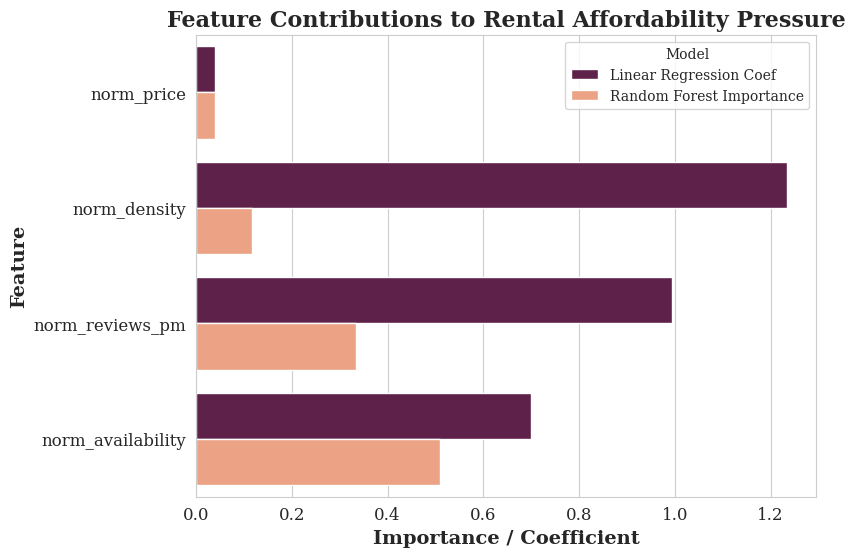

In [15]:
# Linear Regression coefficients
lr_coefficients = pd.Series(lr.coef_, index=features)

# Random Forest feature importances
rf_importances = pd.Series(rf.feature_importances_, index=features)

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Linear Regression Coef': lr_coefficients,
    'Random Forest Importance': rf_importances
})

# Melt the DataFrame for seaborn plotting
importance_melted = importance_df.melt(id_vars='Feature', 
                                       value_vars=['Linear Regression Coef', 
                                                   'Random Forest Importance'],
                                    var_name='Model', value_name='Importance')

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=importance_melted, x='Importance', y='Feature', hue='Model',
            palette=[palette[0],palette[2]])
plt.title("Feature Contributions to Rental Affordability Pressure")
plt.xlabel("Importance / Coefficient")
plt.ylabel("Feature")
plt.legend(title='Model')
plt.show()


In [12]:
# Save importance table to CSV
importance_df = pd.DataFrame({
    'Feature': ['norm_price', 'norm_density', 'norm_reviews_pm', 'norm_availability'],
    'Linear Regression Coef': [0.040078, 1.233157, 0.994041, 0.700062],
    'Random Forest Importance': [0.039350, 0.116167, 0.335033, 0.509449]
})

importance_df.to_csv("../data/processed/feature_importance.csv", index=False)

In [ ]:
# Save normalised wards aggregate to CSV
wards_agg_scaled.to_csv("../data/processed/wards_affordability_model.csv", index=False)

**Observations and Insights**
- Primary drivers: Listing density, reviews per month, and availability exert the strongest influence on the pressure index.
- Minimal impact of price: Price consistently contributes least, indicating that high costs alone do not drive internal pressure.
- Model differences: Linear Regression emphasizes density and reviews, whereas Random Forest highlights availability, reflecting non-linear interactions.
- Implications: Affordability and availability stress is largely shaped by active short-term rental activity, rather than high pricing, highlighting the importance of occupancy patterns and market turnover.

## Final notes
- The Affordability Pressure Index is formalised by modeling the internal relationships between the key metrics identified in previous notebooks and the composite pressure index.
- Using Linear Regression and Random Forest models, the analysis identified which short-term rental activity factors contribute most to pressure within Cape Town wards. 
- In summary, high listing density, turnover (reviews per month), and availability drive the pressure index, while price has minimal impact.
- The modelling exercise confirms that high short term rental activity creates measurable pressure on housing affordability and availability across wards, with non-linear interactions captured by Random Forests offering additional insight.
- Feature importance visualizations provide an interpretable view of which factors dominate pressure in different wards, reinforcing the spatial patterns observed in Notebook 3.
- The outputs of this notebook, including normalized ward data and feature importance tables, form the foundation for the final notebook, where visualizations and reporting will consolidate the analysis into actionable insights and policy-relevant interpretations.